# Breast cancer best_knn

In [1]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    auc,
    roc_curve,
    RocCurveDisplay
)

## Dataset

In [3]:
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)
breast_cancer_wisconsin_original.metadata

{'uci_id': 15,
 'name': 'Breast Cancer Wisconsin (Original)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original',
 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv',
 'abstract': 'Original Wisconsin Breast Cancer Database',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 699,
 'num_features': 9,
 'feature_types': ['Integer'],
 'demographics': [],
 'target_col': ['Class'],
 'index_col': ['Sample_code_number'],
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1990,
 'last_updated': 'Sun Mar 10 2024',
 'dataset_doi': '10.24432/C5HP4Z',
 'creators': ['WIlliam Wolberg'],
 'intro_paper': None,
 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, ha

In [4]:
breast_cancer_wisconsin_original.variables

,name,role,type,demographic,description,units,missing_values
0,Sample_code_number,ID,Categorical,None,None,None,no
1,Clump_thickness,Feature,Integer,None,None,None,no
2,Uniformity_of_cell_size,Feature,Integer,None,None,None,no
3,Uniformity_of_cell_shape,Feature,Integer,None,None,None,no
4,Marginal_adhesion,Feature,Integer,None,None,None,no
5,Single_epithelial_cell_size,Feature,Integer,None,None,None,no
6,Bare_nuclei,Feature,Integer,None,None,None,yes
7,Bland_chromatin,Feature,Integer,None,None,None,no
8,Normal_nucleoli,Feature,Integer,None,None,None,no
9,Mitoses,Feature,Integer,None,None,None,no


In [5]:
# Data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

X.tail()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
694,3,1,1,1,3,2.0,1,1,1
695,2,1,1,1,2,1.0,1,1,1
696,5,10,10,3,7,3.0,8,10,2
697,4,8,6,4,3,4.0,10,6,1
698,4,8,8,5,4,5.0,10,4,1


In [6]:
y.tail()

,Class
694,2
695,2
696,4
697,4
698,4


### Explicação das Colunas do Dataset

O dataset contém características extraídas de imagens digitalizadas de biópsias de mama. Cada linha representa uma amostra e cada coluna representa uma característica analisada microscopicamente. As explicações de cada coluna são:

1. **Espessura_do_aglomerado (Clump_thickness):**
   - Mede a espessura dos aglomerados celulares. Valores maiores podem indicar a presença de células cancerígenas, que geralmente se agrupam de forma densa.

2. **Uniformidade_tamanho_celular (Uniformity_of_cell_size):**
   - Avalia a consistência do tamanho das células. Maior variabilidade pode indicar malignidade.

3. **Uniformidade_forma_celular (Uniformity_of_cell_shape):**
   - Analisa a uniformidade das formas celulares. Células cancerígenas apresentam formas mais irregulares.

4. **Adesao_marginal (Marginal_adhesion):**
   - Mede a força de adesão entre células. Células normais aderem melhor umas às outras do que as malignas.

5. **Tamanho_celular_epitelial_unica (Single_epithelial_cell_size):**
   - Avalia o tamanho de células epiteliais individuais. Células maiores podem estar associadas a câncer.

6. **Nucleos_nus (Bare_nuclei):**
   - Contagem de núcleos sem citoplasma visível. Este é um indicador importante de malignidade.

7. **Cromatina_suave (Bland_chromatin):**
   - Mede a textura da cromatina (material genético no núcleo). A textura suave é típica de células normais.

8. **Nucleolos_normais (Normal_nucleoli):**
   - Quantifica o número de nucléolos (estruturas no núcleo). Números elevados podem estar associados a câncer.

9. **Mitose (Mitoses):**
   - Mede a taxa de divisão celular. Taxas altas são um indicador claro de malignidade.

10. **Classe_Binaria:**
    - Classe alvo do problema, representando:
      - `0`: Tumor benigno.
      - `1`: Tumor maligno.


### Distribuição do dataset

In [7]:
# Combinar X e y em um único DataFrame
full_dataset = X.copy()  # Criar uma cópia do DataFrame X
full_dataset['Class'] = y  # Adicionar a coluna 'Class' de y

full_dataset.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Clump_thickness,699.0,4.418,2.816,1.0,2.0,4.0,6.0,10.0
Uniformity_of_cell_size,699.0,3.134,3.051,1.0,1.0,1.0,5.0,10.0
Uniformity_of_cell_shape,699.0,3.207,2.972,1.0,1.0,1.0,5.0,10.0
Marginal_adhesion,699.0,2.807,2.855,1.0,1.0,1.0,4.0,10.0
Single_epithelial_cell_size,699.0,3.216,2.214,1.0,2.0,2.0,4.0,10.0
Bare_nuclei,683.0,3.545,3.644,1.0,1.0,1.0,6.0,10.0
Bland_chromatin,699.0,3.438,2.438,1.0,2.0,3.0,5.0,10.0
Normal_nucleoli,699.0,2.867,3.054,1.0,1.0,1.0,4.0,10.0
Mitoses,699.0,1.589,1.715,1.0,1.0,1.0,1.0,10.0
Class,699.0,2.690,0.951,2.0,2.0,2.0,4.0,4.0


O dataset aparenta estar bem distribuido

In [8]:
class_counts = y.value_counts()
class_counts

Class
2        458
4        241
Name: count, dtype: int64

Já que temos apenas 2 classes, vamos transforma-la em binária.

In [9]:
y = y.replace({2: 0, 4: 1})
class_counts = y.value_counts()
class_counts

Class
0        458
1        241
Name: count, dtype: int64

In [10]:
full_dataset['Class'] = y

### Valores nulos:

In [11]:
X.isna().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

Since we have 16 missing values on Bare_nuclei, we will handle that.

In [12]:
X[X['Bare_nuclei'].isna()]

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
23,8,4,5,1,2,NaN,7,3,1
40,6,6,6,9,6,NaN,7,8,1
139,1,1,1,1,1,NaN,2,1,1
145,1,1,3,1,2,NaN,2,1,1
158,1,1,2,1,3,NaN,1,1,1
164,5,1,1,1,2,NaN,3,1,1
235,3,1,4,1,2,NaN,3,1,1
249,3,1,1,1,2,NaN,3,1,1
275,3,1,3,1,2,NaN,2,1,1
292,8,8,8,1,2,NaN,6,10,1


In [13]:
# Fill missing values in 'Bare_nuclei' with the most frequent value
most_frequent_value = X['Bare_nuclei'].mode()[0]
X.loc[:, 'Bare_nuclei'] = X['Bare_nuclei'].fillna(most_frequent_value)

# Verify if there are any more missing values
X.isna().sum()

Clump_thickness                0
Uniformity_of_cell_size        0
Uniformity_of_cell_shape       0
Marginal_adhesion              0
Single_epithelial_cell_size    0
Bare_nuclei                    0
Bland_chromatin                0
Normal_nucleoli                0
Mitoses                        0
dtype: int64

In [14]:
duplicate_rows = full_dataset[full_dataset.duplicated()]

if not duplicate_rows.empty:
    print("Linhas duplicadas:")
    print(duplicate_rows)
else:
    print("Nenhuma linha duplicada foi achada.")

Linhas duplicadas:
     Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
28                 2                        1                         1   
35                 2                        1                         1   
48                 4                        1                         1   
64                 1                        1                         1   
66                 4                        1                         1   
..               ...                      ...                       ...   
686                1                        1                         1   
688                4                        1                         1   
690                1                        1                         1   
692                3                        1                         1   
695                2                        1                         1   

     Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei  \
28          

In [15]:
# X = X.drop_duplicates()
# duplicated_rows_after_removal = X[X.duplicated()]

# if not duplicated_rows_after_removal.empty:
#     print("Linhas duplicadas:")
#     print(duplicated_rows_after_removal)
# print("Linhas duplicadas removidas.")

## Visualizações dos dados

In [16]:
# Palete de cores personalizadas para 'não benigno' (cinza) e 'benigno 1' (vermelho)
custom_palette = {0: 'gray', 1: 'darkred'}

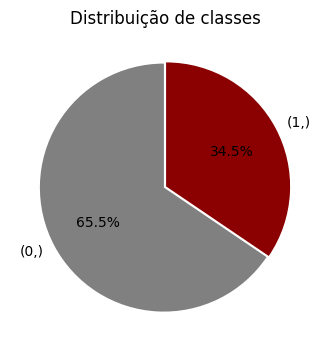

In [17]:
plt.figure(figsize=(4, 5))
class_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=[custom_palette.get(0), custom_palette.get(1)],
    labels=class_counts.index,
    explode=(0.01, 0.01)  # Separando a primeira fatia
)

plt.title('Distribuição de classes')
plt.ylabel('')  # Remove o label do eixo Y
plt.show()

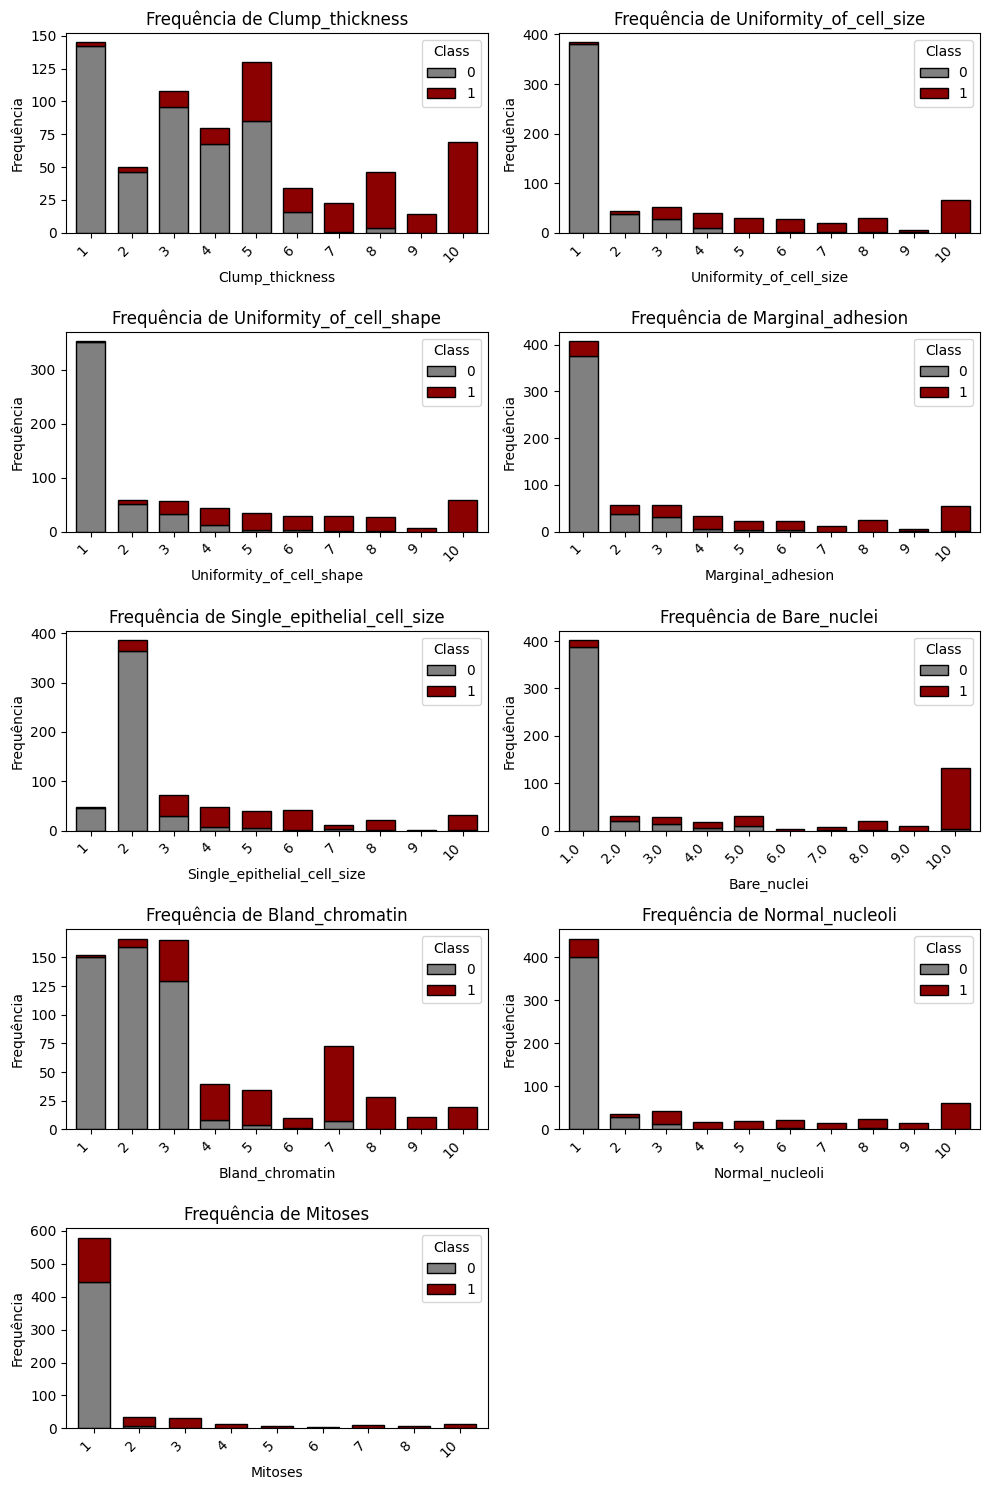

In [18]:
# Número de colunas e linhas para os subplots
num_columns = len(X.columns)
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 3 * num_rows))

# Plotar cada atributo em gráficos de barras empilhadas
for i, column in enumerate(X.columns, 1):
    plt.subplot(num_rows, 2, i)

    # Contagem das ocorrências de cada classe para cada valor da coluna
    count_data = full_dataset.groupby([column, 'Class']).size().unstack(fill_value=0)

    # Plotando barras empilhadas
    count_data.plot(kind='bar', stacked=True, color=custom_palette,
                    ax=plt.gca(), width=0.7, edgecolor='black')  # Ajuste de largura e contorno preto

    plt.title(f'Frequência de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


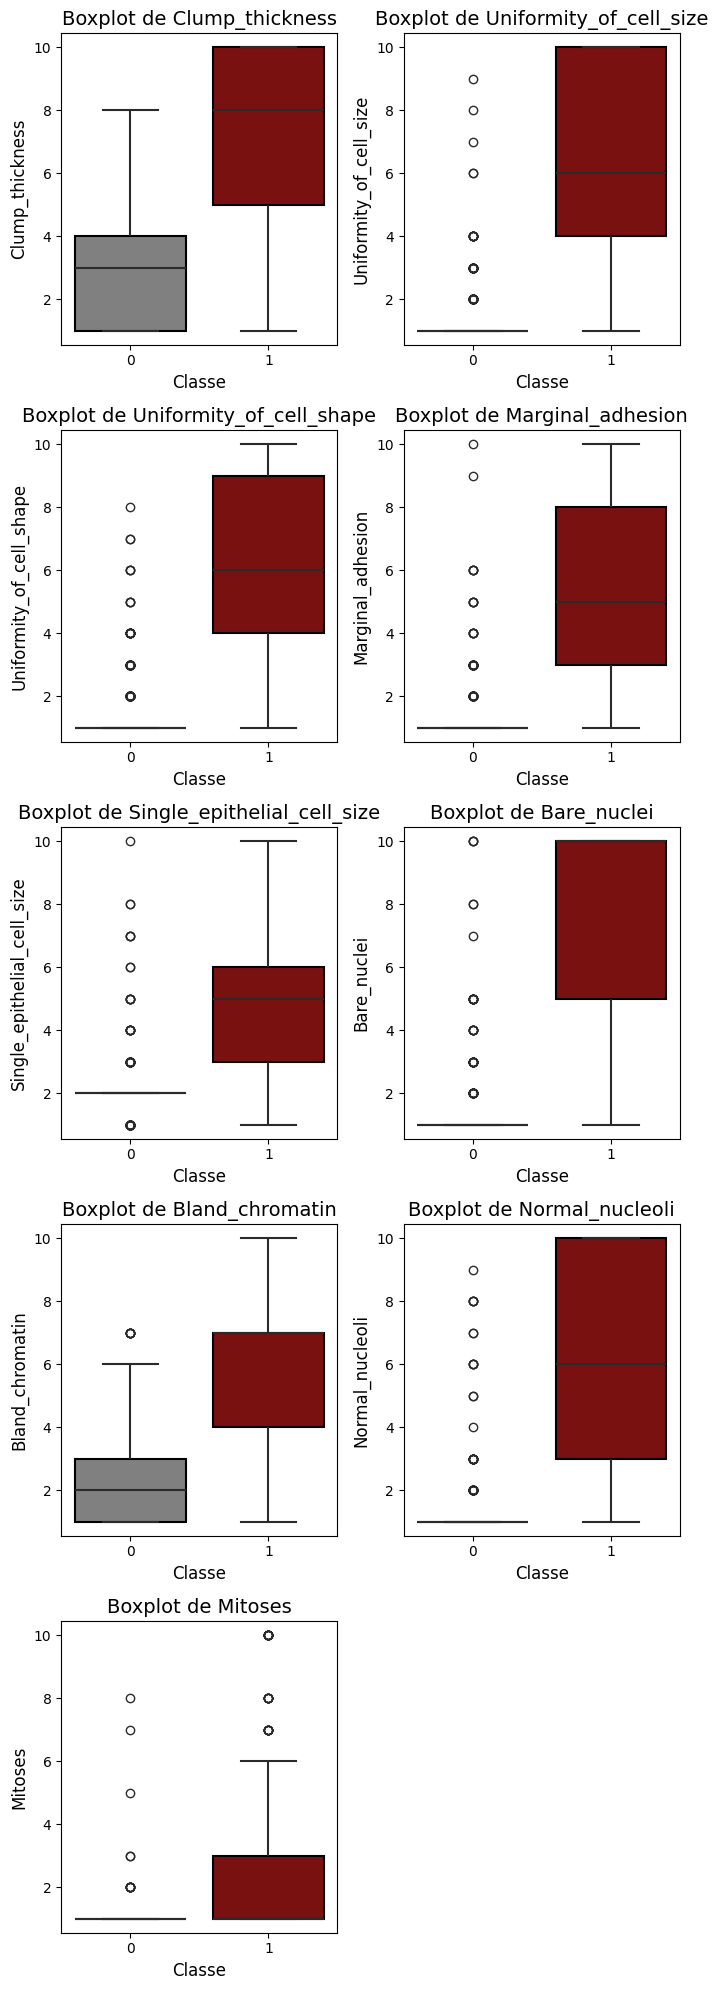

In [19]:
plt.figure(figsize=(7, 4 * num_rows))  # Aumentando o tamanho da figura para mais espaço

# Plotar Boxplot para cada atributo
for i, column in enumerate(X.columns, 1):
    plt.subplot(num_rows, 2, i)
    sns.boxplot(x='Class', y=column, data=full_dataset, hue='Class', palette=custom_palette,
                linewidth=1.5, fliersize=6, boxprops=dict(edgecolor="black"), legend=False)  # Contorno nas caixas e tamanho dos outliers

    plt.title(f'Boxplot de {column}', fontsize=14)
    plt.xlabel('Classe', fontsize=12)
    plt.ylabel(column, fontsize=12)

    # Rotacionar os rótulos do eixo X, se necessário
    plt.xticks(rotation=0)
    # Ajustar o espaçamento do eixo X (diminuir o espaçamento das barras)
    plt.subplots_adjust(bottom=0.15, hspace=0.4)

plt.tight_layout()
plt.show()


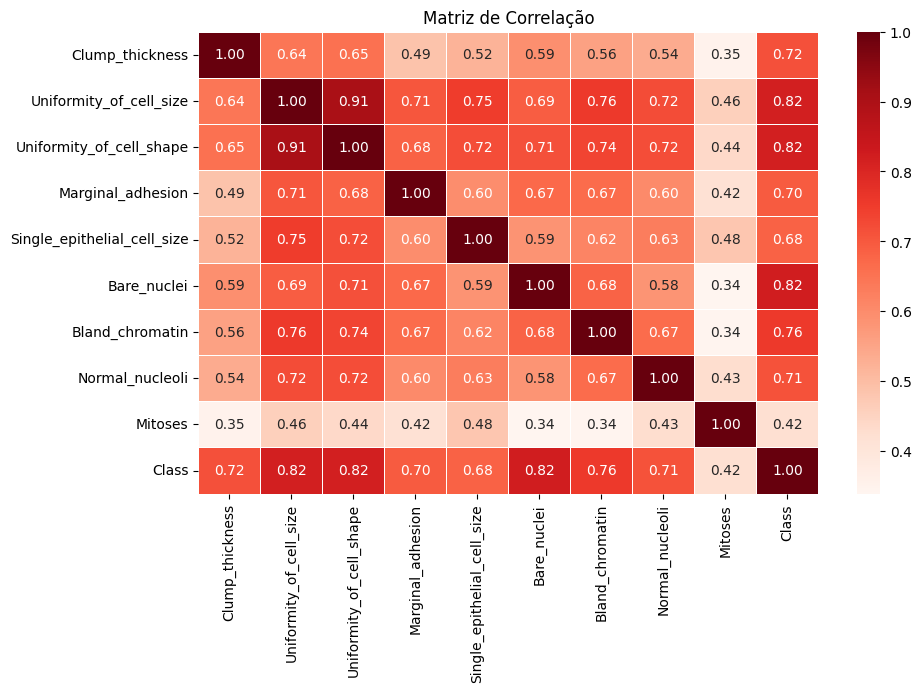

In [20]:
correlation_matrix = full_dataset.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()


## Treinamento

Vamos treinar com diferentes números de vizinhos com o objetivo de saber qual número ideal em q o modelo consegue ter uma boa performance e ser generalista.

In [38]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()  # transformando em um vetor 1d
y_test = y_test.values.ravel()

# Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [39]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

In [46]:
plt.figure(figsize=(10, 8))

# Treinar e avaliar modelos para diferentes valores de k
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
best_k = None
best_knn = None
best_auc = 0
best_accuracy = 0

for i, k in enumerate(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Avaliar a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print(f"k = {k}: Acurácia = {accuracy:.4f}")

    # Salvar o melhor modelo com base na acurácia
    if accuracy > best_accuracy:
        best_accuracy = accuracy
    
    # Fazer previsões probabilísticas
    y_prob = knn.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
    
    # Calcular curva ROC e AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    roc_auc = auc(fpr, tpr)

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_knn = knn 
        best_k = k
    
    print(f"       auc = {roc_auc:.4f}")

print(f"Melhor modelo: com k = {best_k} com AUC = {best_auc:.4f}")


k = 1: Acurácia = 0.9357
       auc = 0.9058
k = 2: Acurácia = 0.9214
       auc = 0.9826
k = 3: Acurácia = 0.9714
       auc = 0.9825
k = 4: Acurácia = 0.9643
       auc = 0.9865
k = 5: Acurácia = 0.9714
       auc = 0.9986
k = 6: Acurácia = 0.9571
       auc = 0.9980
k = 7: Acurácia = 0.9714
       auc = 0.9978
k = 8: Acurácia = 0.9714
       auc = 0.9974
k = 9: Acurácia = 0.9714
       auc = 0.9966
k = 10: Acurácia = 0.9643
       auc = 0.9964
Melhor modelo: com k = 5 com AUC = 0.9986


<Figure size 1000x800 with 0 Axes>

### Visualização da região de decisão com PCA

In [47]:
# PCA e plot da região de decisão usando o melhor modelo
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Treinar o modelo novamente com os dados reduzidos (após PCA)
best_knn_pca = KNeighborsClassifier(n_neighbors=best_k)
best_knn_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

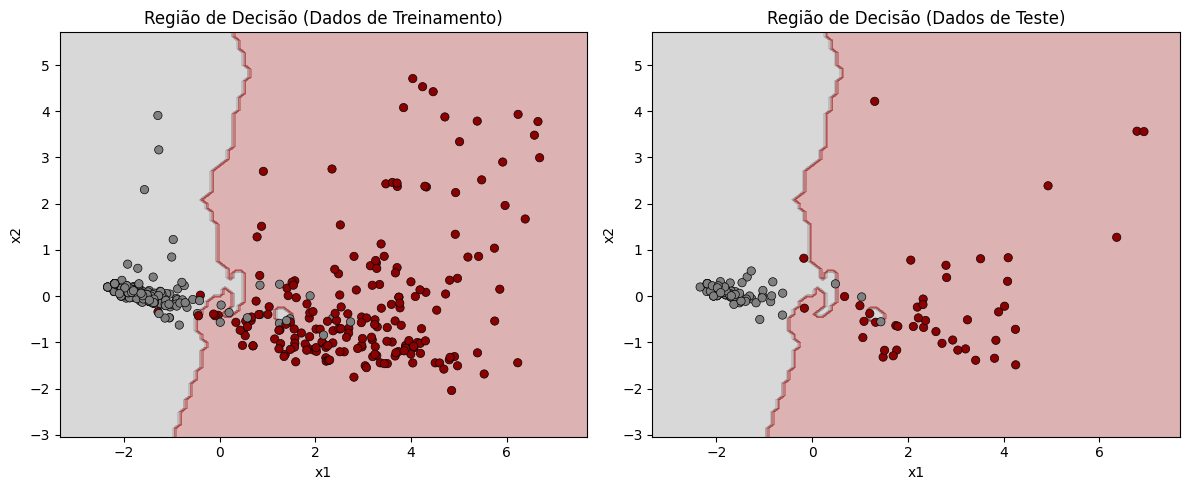

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)

# **Gráfico para os dados de treinamento**
DecisionBoundaryDisplay.from_estimator(
    best_knn_pca,
    X_train_pca,
    response_method="predict",
    cmap=ListedColormap([custom_palette[0], custom_palette[1]]),
    alpha=0.3,
    ax=ax1,
)

sns.scatterplot(
    x=X_train_pca[:, 0], 
    y=X_train_pca[:, 1], 
    hue=y_train, 
    palette=custom_palette, 
    ax=ax1, 
    edgecolor='k', 
    legend=False
)

ax1.set_title("Região de Decisão (Dados de Treinamento)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

# **Gráfico para os dados de teste**
DecisionBoundaryDisplay.from_estimator(
    best_knn_pca,
    X_train_pca,
    response_method="predict",
    cmap=ListedColormap([custom_palette[0], custom_palette[1]]),
    alpha=0.3,
    ax=ax2,
)

sns.scatterplot(
    x=X_test_pca[:, 0], 
    y=X_test_pca[:, 1], 
    hue=y_test, 
    palette=custom_palette, 
    ax=ax2, 
    edgecolor='k', 
    legend=False
)

ax2.set_title("Região de Decisão (Dados de Teste)")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

plt.tight_layout()
plt.show()

## Análise da performance dos modelos

### Relatório de classificação (Precision, Recall, F1-Score para cada classe)

#### Precisão:
Fração de previsões corretas para a classe positiva:
$$
\text{Precisão} = \frac{\text{VP}}{\text{VP} + \text{FP}}
$$

#### Revocação:
Fração de exemplos positivos corretamente identificados:
$$
\text{Revocação} = \frac{\text{VP}}{\text{VP} + \text{FN}}
$$

#### F1-Score:
Média harmônica entre Precisão e Revocação:
$$
\text{F1-Score} = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}}
$$


In [49]:
class_report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(class_report)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        95
           1       0.98      0.91      0.94        45

    accuracy                           0.96       140
   macro avg       0.97      0.95      0.96       140
weighted avg       0.96      0.96      0.96       140



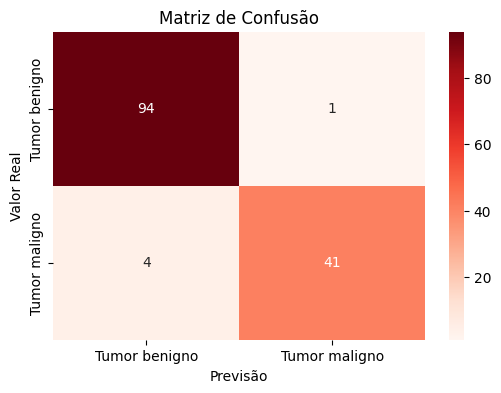

In [50]:
# 1. Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=['Tumor benigno', 'Tumor maligno'], yticklabels=['Tumor benigno', 'Tumor maligno'])
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão")
plt.show()

### ROC-AUC Score e curva ROC

ROC-AUC Score: Mede a separabilidade das classes com base nas probabilidades previstas. Um AUC de 1 indica classificação perfeita.

Curva ROC: Mostra a relação entre True Positive Rate (TPR) e False Positive Rate (FPR) para diferentes limiares.

ROC-AUC Score: 1.00


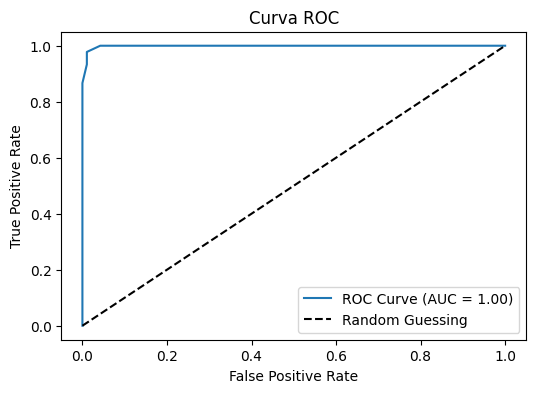

Acurácia do modelo k-NN: 0.96


In [51]:
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo k-NN: {accuracy:.2f}")